# 回測

,Total P&L,Max Drawdown,Total Trades,Percent Profitable,Profit Factor
Overview performance,53.25%,-38.81%,130,45.38%,1.56


,Total Trades,Number of Winning Trades,Number of Losing Trades,Average Trade (%),Average Win (%),Average Loss (%),Largest Win (%),Largest Loss (%)
Trades analysis,130,59,71,0.40%,2.62%,-1.44%,16.24%,-12.32%


,Sharpe Ratio,Sortino Ratio,Profit Factor
Risk/performance ratios,1.25,5.26,1.56


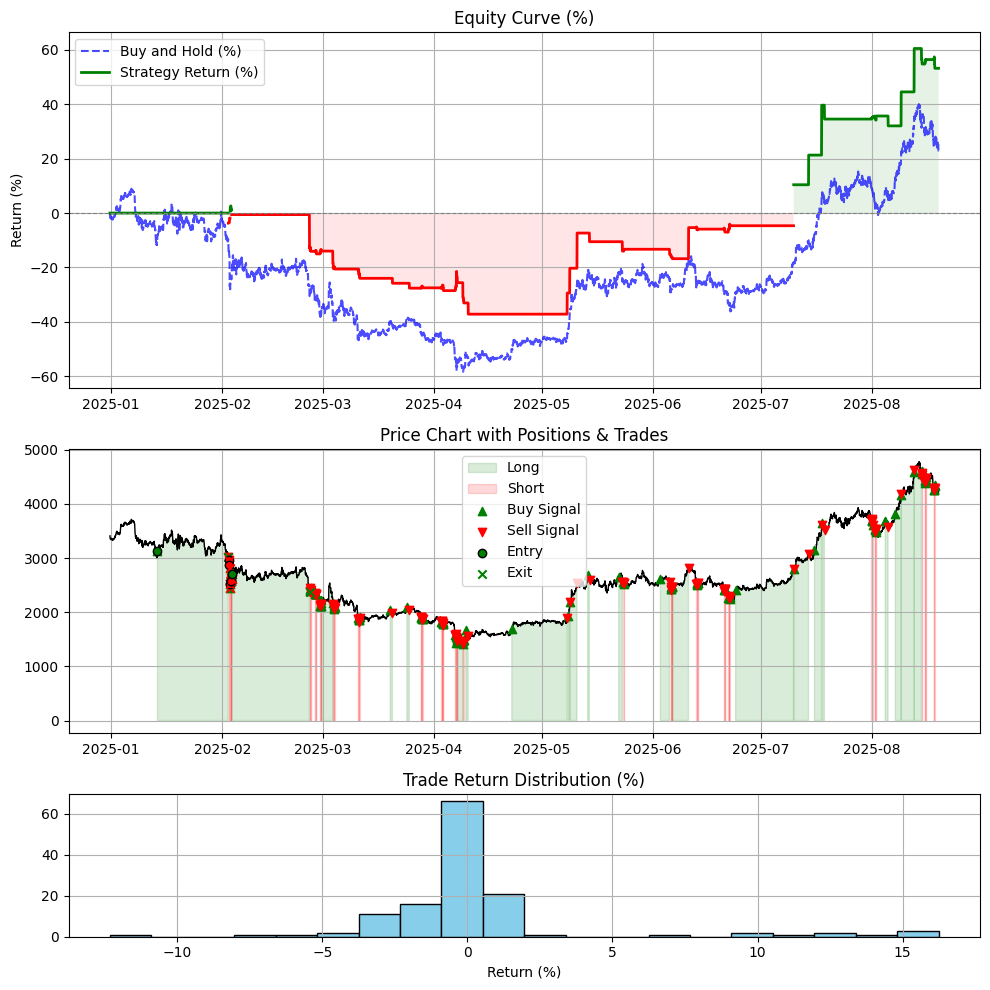

,timestamp,signal,close,reason,stop_loss
5458,2025-08-16 02:00:00,-1,4444.480000,空單進場,4565.419000
5459,2025-08-16 03:00:00,1,4432.240000,空單SL,nan
5511,2025-08-18 07:00:00,-1,4257.470000,空單進場,4358.969000
5512,2025-08-18 08:00:00,1,4259.110000,空單SL,nan
5513,2025-08-18 09:00:00,-1,4292.720000,空單進場,4397.480000
5514,2025-08-18 10:00:00,1,4264.290000,空單SL,nan
5515,2025-08-18 11:00:00,-1,4274.370000,空單進場,4387.731000
5516,2025-08-18 12:00:00,1,4343.300000,空單SL,nan
5517,2025-08-18 13:00:00,-1,4286.130000,空單進場,4401.043000
5518,2025-08-18 14:00:00,1,4333.540000,空單SL,nan


In [2]:
from Technicalindicatorstrategy import bbrank
import warnings 
warnings.filterwarnings('ignore')
from Backtest.backtest import backtest_signals
from Plot.plot import display_trades_log_as_html,plot_backtest_result
from IPython.display import HTML
import pandas as pd
from datetime import datetime,timedelta
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(42)  # ✅ 固定隨機性（可重現性）
import random
random.seed(42)

df_signals = bbrank.get_signals('ETHUSDT','1h',datetime.now(),5544, 
                                lookback = 300, rank_th = 90,
                                ATR_multi_SL = 2.0, ATR_multi_TP = 10.0)

result = backtest_signals(
    df_signals.copy(),
    initial_capital = 1000000, # 1000台幣
    fee_rate = 0.000, # 合約手續費
    leverage = 1, # 槓桿
    allow_short = True, # 是否做空
    stop_loss = None,       # 停損閾值，例如0.05代表5%
    take_profit = None,     # 停利閾值
    capital_ratio = 1, # 每次使用的資金佔比
    max_hold_bars = 100000,# 最大持有K棒數
    delay_entry=False,
    risk_free_rate=0
    )  
display(pd.DataFrame(result['Overview performance'],index=['Overview performance']))
display(pd.DataFrame(result['Trades analysis'],index=['Trades analysis']))
display(pd.DataFrame(result['Risk/performance ratios'],index=['Risk/performance ratios']))
html_output = display_trades_log_as_html(result['trades_log'][-10:])
plot_backtest_result(result)
display(HTML(html_output))
display(df_signals.loc[df_signals['signal']!=0,['timestamp','signal','close','reason','stop_loss']].tail(10).style.background_gradient())

# 交易明細

In [31]:
pd.DataFrame(result['trades_log']).tail(100).style.background_gradient()

,Type,Date/Time (Entry),Date/Time (Exit),Signal (Entry),Signal (Exit),Price (Entry),Price (Exit),Position size,P&L (USDT),P&L (%),Run-up (%),Drawdown (%),Cumulative P&L,Cumulative P&L (%)
34,Short,"2025/03/04, 05:00","2025/03/04, 06:00",空單開倉,空單平倉,"2,106.94","2,097.66","929,086.48","4,110.26",0.44%,1.37%,-0.72%,"-66,803.26",-6.68%
35,Short,"2025/03/04, 07:00","2025/03/04, 08:00",空單開倉,空單平倉,"2,080.41","2,099.03","933,196.74","-8,278.17",-0.89%,0.58%,-1.22%,"-75,081.43",-7.51%
36,Short,"2025/03/10, 20:00","2025/03/10, 21:00",空單開倉,空單平倉,"1,869.18","1,887.30","924,918.57","-8,880.16",-0.96%,1.41%,-1.83%,"-83,961.59",-8.40%
37,Short,"2025/03/10, 22:00","2025/03/10, 23:00",空單開倉,空單平倉,"1,880.02","1,865.10","916,038.41","7,327.91",0.80%,1.21%,-0.82%,"-76,633.68",-7.66%
38,Short,"2025/03/11, 00:00","2025/03/11, 01:00",空單開倉,空單平倉,"1,813.96","1,858.66","923,366.32","-22,206.58",-2.40%,3.40%,-4.05%,"-98,840.25",-9.88%
39,Short,"2025/03/11, 02:00","2025/03/11, 03:00",空單開倉,空單平倉,"1,859.69","1,849.78","901,159.75","4,827.87",0.54%,0.67%,-1.16%,"-94,012.39",-9.40%
40,Short,"2025/03/11, 04:00","2025/03/11, 05:00",空單開倉,空單平倉,"1,869.06","1,893.60","905,987.61","-11,741.09",-1.30%,1.28%,-2.36%,"-105,753.48",-10.58%
41,Short,"2025/03/11, 06:00","2025/03/11, 07:00",空單開倉,空單平倉,"1,884.83","1,904.10","894,246.52","-9,050.01",-1.01%,0.16%,-1.27%,"-114,803.49",-11.48%
42,Long,"2025/03/19, 19:00","2025/03/20, 10:00",多單開倉,多單平倉,"2,031.06","1,982.53","885,196.51","-21,150.82",-2.39%,1.91%,-2.89%,"-135,954.31",-13.60%
43,Long,"2025/03/24, 10:00","2025/03/25, 03:00",多單開倉,多單平倉,"2,094.23","2,043.26","864,045.69","-21,029.40",-2.43%,0.47%,-2.50%,"-156,983.72",-15.70%


# 策略參數最佳化

## ATR_multi_SL 和 ATR_multi_TP

最佳參數 (Sortino Ratio): SL=5.0, TP=10.0, Value=47.1400
最佳參數 (Sharpe Ratio): SL=5.0, TP=8.0, Value=1.9800


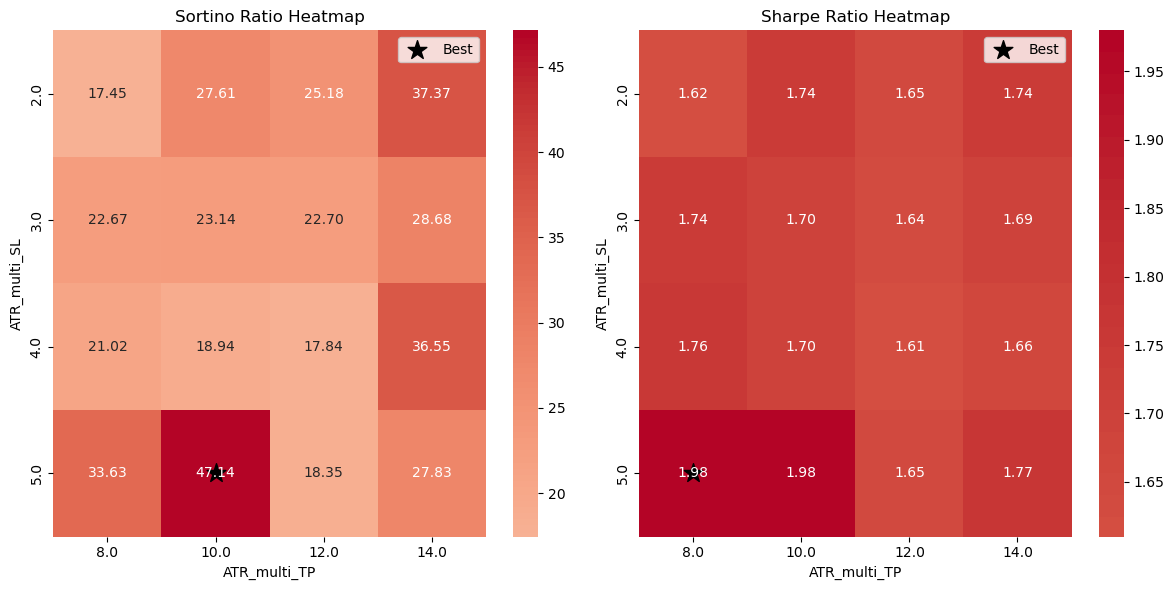

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from Technicalindicatorstrategy import bbrank
from Backtest.backtest import backtest_signals
import random

# 固定隨機性
np.random.seed(42)
random.seed(42)

def grid_search_all_metrics_subplot(
    symbol="ETHUSDT", 
    interval="1h", 
    bars=3000, 
    p1_values=np.arange(2.0, 5.1, 1),
    p2_values=np.arange(8.0, 14.1, 2.0),
    metrics=["Sortino Ratio", "Sharpe Ratio"]
):
    """
    對 ATR_multi_SL 和 ATR_multi_TP 進行 Grid Search 
    並一次性在 subplot 中畫出多個績效指標的熱力圖
    """

    results = []

    for p1 in p1_values:
        for p2 in p2_values:
            try:
                # 取得信號
                df_signals = bbrank.get_signals(
                    symbol, interval, datetime.now(), bars,
                    ATR_multi_SL = p1, ATR_multi_TP = p2
                )

                # 跑回測
                result = backtest_signals(
                    df_signals.copy(),
                    initial_capital=1000000,
                    fee_rate=0.000,
                    leverage=10,
                    allow_short=True,
                    stop_loss=None,
                    take_profit=None,
                    capital_ratio=0.1,
                    max_hold_bars=100000,
                    delay_entry=False,
                    risk_free_rate=0
                )

                row = {"ATR_multi_SL": p1, "ATR_multi_TP": p2}
                for m in metrics:
                    row[m] = result['Risk/performance ratios'].get(m, np.nan)
                results.append(row)

            except Exception as e:
                print(f"Error at SL={p1}, TP={p2}: {e}")
                row = {"ATR_multi_SL": p1, "ATR_multi_TP": p2}
                for m in metrics:
                    row[m] = np.nan
                results.append(row)

    # 整理 DataFrame
    df_results = pd.DataFrame(results)

    
    # 畫 subplot
    fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 6))

    for i, metric in enumerate(metrics):
        pivot_table = df_results.pivot(
            index="ATR_multi_SL", 
            columns="ATR_multi_TP", 
            values=metric
        ).astype(float)

        # 找最佳值Sortino/Sharpe 要最大化
        best_val = pivot_table.max().max()
        best_loc = np.where(pivot_table == best_val)

        best_sl = pivot_table.index[best_loc[0][0]]
        best_tp = pivot_table.columns[best_loc[1][0]]

        # 畫熱力圖
        sns.heatmap(
            pivot_table, annot=True, fmt=".2f",
            cmap="coolwarm",
            center=0, ax=axes[i]
        )
        axes[i].set_title(f"{metric} Heatmap")
        axes[i].set_ylabel("ATR_multi_SL")
        axes[i].set_xlabel("ATR_multi_TP")

        # 標記最佳點
        axes[i].scatter(
            list(pivot_table.columns).index(best_tp) + 0.5,
            list(pivot_table.index).index(best_sl) + 0.5,
            color="black", marker="*", s=200, label="Best"
        )
        axes[i].legend()

        print(f"最佳參數 ({metric}): SL={best_sl}, TP={best_tp}, Value={best_val:.4f}")

    plt.tight_layout()
    plt.show()

    return df_results

df = grid_search_all_metrics_subplot()

## lookback、rank_th

最佳參數 (Sortino Ratio): p1=500, p2=90, Value=31.2300
最佳參數 (Sharpe Ratio): p1=500, p2=90, Value=1.7600


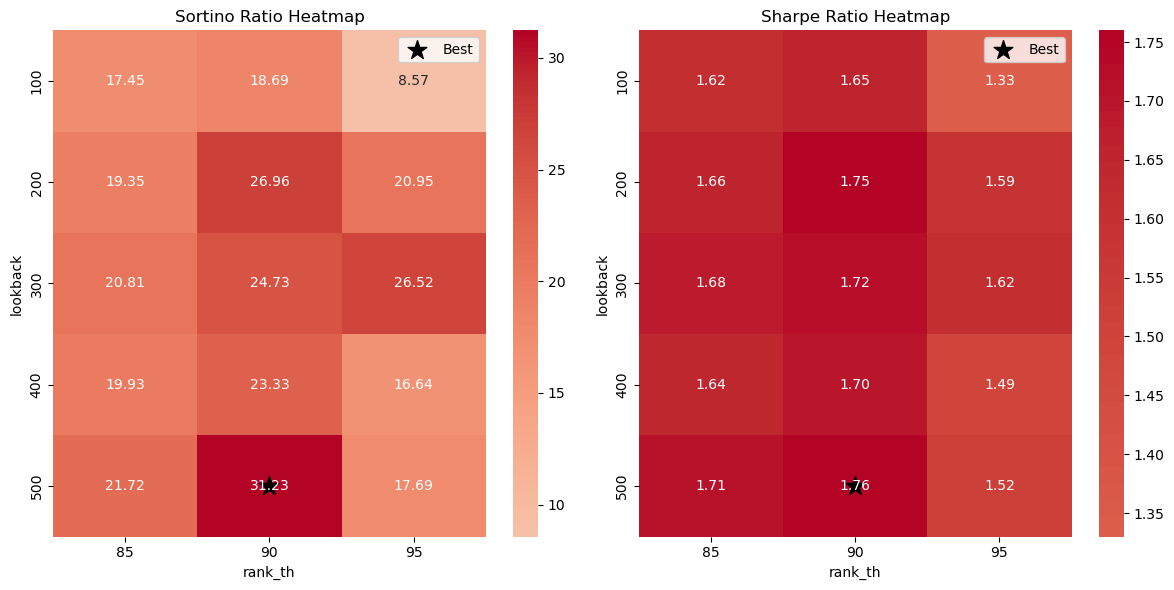

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from Technicalindicatorstrategy import bbrank
from Backtest.backtest import backtest_signals
import random

# 固定隨機性
np.random.seed(42)
random.seed(42)

def grid_search_all_metrics_subplot(
    symbol="ETHUSDT", 
    interval="1h", 
    bars=3000, 
    p1_values=np.arange(100, 501, 100),
    p2_values=np.arange(85, 96, 5),
    metrics=["Sortino Ratio", "Sharpe Ratio"]
):
    """
    對 lookback 和 rank_th 進行 Grid Search 
    並一次性在 subplot 中畫出多個績效指標的熱力圖
    """

    results = []

    for p1 in p1_values:
        for p2 in p2_values:
            try:
                # 取得信號
                df_signals = bbrank.get_signals(
                    symbol, interval, datetime.now(), bars,
                    lookback = p1, rank_th = p2
                )

                # 跑回測
                result = backtest_signals(
                    df_signals.copy(),
                    initial_capital=1000000,
                    fee_rate=0.000,
                    leverage=10,
                    allow_short=True,
                    stop_loss=None,
                    take_profit=None,
                    capital_ratio=0.1,
                    max_hold_bars=100000,
                    delay_entry=False,
                    risk_free_rate=0
                )

                row = {"lookback": p1, "rank_th": p2}
                for m in metrics:
                    row[m] = result['Risk/performance ratios'].get(m, np.nan)
                results.append(row)

            except Exception as e:
                print(f"Error at SL={p1}, TP={p2}: {e}")
                row = {"lookback": p1, "rank_th": p2}
                for m in metrics:
                    row[m] = np.nan
                results.append(row)

    # 整理 DataFrame
    df_results = pd.DataFrame(results)

    
    # 畫 subplot
    fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 6))

    for i, metric in enumerate(metrics):
        pivot_table = df_results.pivot(
            index="lookback", 
            columns="rank_th", 
            values=metric
        ).astype(float)

        # 找最佳值Sortino/Sharpe 要最大化
        best_val = pivot_table.max().max()
        best_loc = np.where(pivot_table == best_val)

        best_sl = pivot_table.index[best_loc[0][0]]
        best_tp = pivot_table.columns[best_loc[1][0]]

        # 畫熱力圖
        sns.heatmap(
            pivot_table, annot=True, fmt=".2f",
            cmap="coolwarm",
            center=0, ax=axes[i]
        )
        axes[i].set_title(f"{metric} Heatmap")
        axes[i].set_ylabel("lookback")
        axes[i].set_xlabel("rank_th")

        # 標記最佳點
        axes[i].scatter(
            list(pivot_table.columns).index(best_tp) + 0.5,
            list(pivot_table.index).index(best_sl) + 0.5,
            color="black", marker="*", s=200, label="Best"
        )
        axes[i].legend()

        print(f"最佳參數 ({metric}): p1={best_sl}, p2={best_tp}, Value={best_val:.4f}")

    plt.tight_layout()
    plt.show()

    return df_results

df = grid_search_all_metrics_subplot()